<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-7/Assignment_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null


  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-7n0gfqfa


In [3]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D
from keras.layers import Input, concatenate
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
import tensorflow as tf
from data_science_utils.vision.keras import *

Using TensorFlow backend.


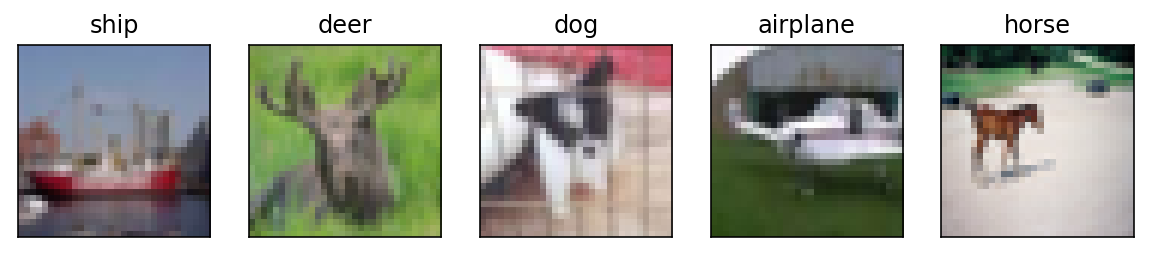

In [4]:

X_train, Y_train, X_test, Y_test = get_cifar10_data()
classes = get_cifar10_labels()
show_examples(X_train[10:15], Y_train[10:15], classes)

In [0]:
def s2d_2(x):
  return tf.space_to_depth(x, block_size=2)

def s2d_4(x):
  return tf.space_to_depth(x, block_size=4)

def transition_layer(inputs, n_kernels=32):
  out = Conv2D(n_kernels,
                kernel_size=(1,1),
                strides=1,
                padding='same',
                kernel_regularizer=l2(1e-4),
                dilation_rate=1)(inputs)
  out = BatchNormalization()(out)
  out = Activation("relu")(out)
  return out

def conv_layer(inputs, n_kernels=32, kernel_size=(3,3), dropout=0.15,dilation_rate=1, padding='same', 
               skip_1=True,skip_2=True, enable_transition = True,transition_layer_kernels = 32):
  inputs = concatenate(inputs) if len(inputs)>1 else inputs[0]
  inputs = transition_layer(inputs, transition_layer_kernels) if enable_transition else inputs
  out = Conv2D(n_kernels,
                kernel_size=kernel_size,
                strides=1,
                padding=padding,
                kernel_regularizer=l2(2e-4),
                dilation_rate=dilation_rate)(inputs)
  out = BatchNormalization()(out)
  out = Activation("relu")(out)
  out = Dropout(dropout)(out) if dropout>0 else out
  out_skip_1 = Lambda(s2d_2)(out) if skip_1 else None
  out_skip_2 = Lambda(s2d_4)(out) if skip_2 else None
  return out, out_skip_1, out_skip_2

def depthwise_conv_layer(inputs, n_kernels=32, kernel_size=(3,3),dropout=0.15,dilation_rate=1, padding='same', depth_multiplier=1,
                         skip_1=True,skip_2=True, enable_transition = False,transition_layer_kernels = 32):
  inputs = concatenate(inputs) if len(inputs)>1 else inputs[0]
  inputs = transition_layer(inputs, transition_layer_kernels) if enable_transition else inputs
  out = SeparableConv2D(n_kernels,
                kernel_size=kernel_size,
                strides=1,
                padding=padding,
                kernel_regularizer=l2(2e-4),
                dilation_rate=dilation_rate,
                depth_multiplier=depth_multiplier,)(inputs)
  out = BatchNormalization()(out)
  out = Activation("relu")(out)
  out = Dropout(dropout)(out) if dropout>0 else out
  out_skip_1 = Lambda(s2d_2)(out) if skip_1 else None
  out_skip_2 = Lambda(s2d_4)(out) if skip_2 else None
  return out, out_skip_1, out_skip_2



def output_layer(inputs, n_classes):
  inputs = concatenate(inputs) if len(inputs)>1 else inputs[0]
  out = transition_layer(inputs, n_classes)
  out = GlobalAveragePooling2D()(out)
  out = Activation("softmax")(out)
  return out





# Model Definition

## Block 1

In [6]:
inputs = Input(shape=(32,32,3))
layer_1, layer_1_s1,layer_1_s2 = depthwise_conv_layer([inputs], n_kernels=16,kernel_size=(5,5))
layer_2, _, layer_2_s2 = conv_layer([layer_1],n_kernels=32,kernel_size=(5,5))
layer_3, layer_3_s1, layer_3_s2 = conv_layer([layer_2],n_kernels=64,kernel_size=(5,5))
layer_4, layer_4_s1, layer_4_s2 = depthwise_conv_layer([layer_3,layer_1], n_kernels=32,kernel_size=(5,5), enable_transition = True,transition_layer_kernels = 16) 

layer_5 = MaxPooling2D()(concatenate([layer_1,layer_4])) # 16






W0622 03:46:32.556321 140205627406208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 03:46:32.573074 140205627406208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 03:46:32.577010 140205627406208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0622 03:46:32.611861 140205627406208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0622 03:46:32.612713 1402056274

## Block 2

In [0]:

layer_6,layer_6_s1,_ = depthwise_conv_layer([layer_5], 
                                            n_kernels=32,kernel_size=(3,3),enable_transition = True,transition_layer_kernels = 32) 

# 

layer_7,layer_7_s1,_ = conv_layer([layer_4_s1,layer_1_s1,layer_6],
                                  n_kernels=32,kernel_size=(5,5),enable_transition = True,transition_layer_kernels = 32)

#

layer_8,layer_8_s1,_ = depthwise_conv_layer([layer_7,layer_6,layer_4_s1,layer_3_s1], 
                                            n_kernels=64,kernel_size=(3,3),enable_transition = True,transition_layer_kernels = 32) 

#

layer_9,layer_9_s1,_ = depthwise_conv_layer([layer_8,layer_7,layer_3_s1, layer_4_s1,layer_6, layer_1_s1], 
                                            n_kernels=64,kernel_size=(5,5), enable_transition = True,transition_layer_kernels = 32) 

#

layer_10 = MaxPooling2D()(concatenate([layer_9,layer_8,layer_6,layer_1_s1,layer_4_s1])) # 8





## Block 3

In [0]:
layer_11,_,_ = conv_layer([layer_10,layer_7_s1],
                          n_kernels=32,kernel_size=(5,5),enable_transition = True,transition_layer_kernels = 32)
#

layer_12,_,_ = depthwise_conv_layer([layer_11,layer_2_s2,layer_8_s1,layer_4_s2], 
                                    n_kernels=32,kernel_size=(5,5),enable_transition = True,transition_layer_kernels = 32) 
#

layer_13,_,_ = conv_layer([layer_2_s2,layer_3_s2,layer_11,layer_12,layer_6_s1],
                          n_kernels=64,kernel_size=(3,3),enable_transition = True,transition_layer_kernels = 32)
#

layer_14,_,_ = depthwise_conv_layer([layer_8_s1,layer_3_s2,layer_13,layer_12,layer_4_s2,layer_6_s1,layer_1_s2],
                                    n_kernels=64,kernel_size=(5,5),enable_transition = True,transition_layer_kernels = 32)
#

output = output_layer([layer_14,layer_8_s1,layer_12,layer_4_s2],
                      10)


In [9]:

model = Model(inputs=inputs, outputs=output)

optimizer = Adam(lr=0.001,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])
model.count_params()

W0622 03:46:35.921602 140205627406208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



401277

# Training

In [10]:
X_train, Y_train, X_test, Y_test = get_cifar10_data(preprocess=False)
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             rotation_range=10,
                             height_shift_range=0.1,width_shift_range=0.1,zoom_range=0.1,horizontal_flip=False)

datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen.fit(X_train)
datagen_validation.fit(X_train)

train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
validation_iterator = datagen.flow(X_test, Y_test, batch_size=256,shuffle=True)

checkpoint = ModelCheckpoint("model.hdf5", monitor='acc', verbose=0, save_best_only=True, mode='max')
clr = CyclicLR(base_lr=0.0002, max_lr=0.005,step_size=800, mode='triangular2')
callbacks_list = [checkpoint,clr]
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=100, verbose=1,
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])

model.load_weights("model.hdf5")


iterator = datagen.flow(X_train, Y_train, batch_size=256, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=256, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_cifar10_labels(),print_results=True, plot_results=False)


iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=256, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)

W0622 03:46:51.343500 140205627406208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
196/196 [==============================] - 47s 242ms/step - loss: 1.9421 - acc: 0.3614 - val_loss: 2.0348 - val_acc: 0.3367
Epoch 2/100
196/196 [==============================] - 40s 202ms/step - loss: 1.4586 - acc: 0.5432 - val_loss: 3.6039 - val_acc: 0.2621
Epoch 3/100
196/196 [==============================] - 39s 201ms/step - loss: 1.2164 - acc: 0.6274 - val_loss: 1.8019 - val_acc: 0.5050
Epoch 4/100
196/196 [==============================] - 39s 199ms/step - loss: 1.0940 - acc: 0.6757 - val_loss: 2.0040 - val_acc: 0.4708
Epoch 5/100
196/196 [==============================] - 39s 200ms/step - loss: 1.0170 - acc: 0.7087 - val_loss: 1.1714 - val_acc: 0.6648
Epoch 6/100
196/196 [==============================] - 39s 199ms/step - loss: 0.9182 - acc: 0.7420 - val_loss: 1.1365 - val_acc: 0.6628
Epoch 7/100
196/196 [==============================] - 39s 200ms/step - loss: 0.8253 - acc: 0.7725 - val_loss: 1.1236 - val_acc: 0.6707
Epoch 8/100
196/196 [===========================

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
m2d = model_to_dot(model, show_shapes=True,)
m2d.set_size('24x36')
SVG(m2d.create(prog='dot', format='svg'))

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)